based on https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview

In [41]:
!cp kaggle.json /content

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
!ls /content

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/content


In [2]:
import numpy as np
import pandas as pd 

In [3]:
!pip install kaggle --upgrade

In [4]:

## set up custom path to kaggle.json: 
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

from pathlib import Path
path = Path('word2vec-nlp-tutorial')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    # for each zip file in the path unzip it
    for f in path.glob('*.zip'):
        zipfile.ZipFile(f).extractall(path)

In [5]:
train =  pd.read_csv(path/'labeledTrainData.tsv',sep='\t')
# change type of sentiment to float for later use as transformer target label 
train['sentiment'] = train['sentiment'].astype(np.float16)

train.head()

,id,sentiment,review
0,5814_8,1.0,With all this stuff going down at the moment w...
1,2381_9,1.0,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0.0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0.0,It must be assumed that those who praised this...
4,9495_8,1.0,Superbly trashy and wondrously unpretentious 8...


In [6]:
train.review[0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [7]:
lengths = train.review.apply(lambda x: len(x.split()))
lengths.describe()

count    25000.000000
mean       233.787640
std        173.733321
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: review, dtype: float64

In [8]:
lengths[lengths > 500].describe()

count    2018.000000
mean      690.615956
std       169.074252
min       501.000000
25%       560.000000
50%       643.500000
75%       787.000000
max      2470.000000
Name: review, dtype: float64

<AxesSubplot: >

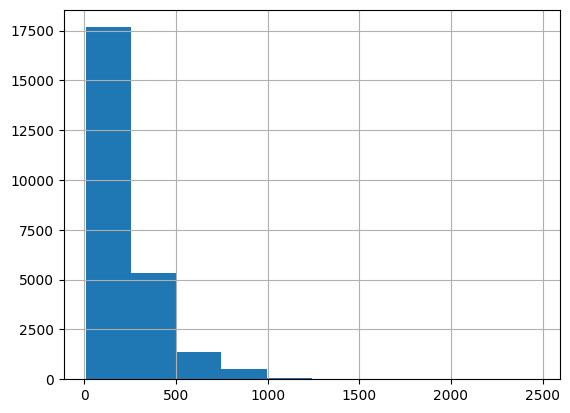

In [9]:
lengths.hist()

transformers as per https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners

In [10]:
filtered_train = train
## cuts reviews to 100 words
filtered_train['review'] = filtered_train['review'].apply(lambda x: ' '.join(x.split()[:100]))

In [11]:
from datasets import Dataset,DatasetDict
ds = Dataset.from_pandas(filtered_train)
ds

Dataset({
    features: ['id', 'sentiment', 'review'],
    num_rows: 25000
})

In [12]:
model_nm = 'microsoft/deberta-v3-small'
from transformers import AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:434: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [13]:
def tok_func(x): return tokz(x["review"])

In [14]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

In [15]:
tok_ds

Dataset({
    features: ['id', 'sentiment', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})

In [16]:
tok_ds = tok_ds.rename_column('sentiment','labels')

In [17]:
len(tok_ds['input_ids'][3])

152

In [18]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'labels', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 18750
    })
    test: Dataset({
        features: ['id', 'labels', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6250
    })
})

In [19]:
dds['train']['labels'].count(1), dds['train']['labels'].count(0)

(9421, 9329)

In [20]:
dds['test']['labels'].count(1), dds['test']['labels'].count(0)

(3079, 3171)

In [21]:
def corr(x,y): return np.corrcoef(x,y)[0][1]
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [22]:
# corr_d([train.sentiment, train.sentiment])

In [23]:
from transformers import TrainingArguments,Trainer


In [24]:
bs = 32
epochs = 1
lr = 8e-5

args = TrainingArguments('hf-output', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')


In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [26]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: review, id. If review, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 18750
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 586


Epoch,Training Loss,Validation Loss


Saving model checkpoint to hf-output/checkpoint-500
Configuration saved in hf-output/checkpoint-500/config.json
Configuration saved in hf-output/checkpoint-500/config.json
Model weights saved in hf-output/checkpoint-500/pytorch_model.bin
tokenizer config file saved in hf-output/checkpoint-500/tokenizer_config.json
Special tokens file saved in hf-output/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: review, id. If review, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 6250
  Batch size = 64


TrainOutput(global_step=586, training_loss=0.11301938014632606, metrics={'train_runtime': 108.1907, 'train_samples_per_second': 173.305, 'train_steps_per_second': 5.416, 'total_flos': 800177862292860.0, 'train_loss': 0.11301938014632606, 'epoch': 1.0})

In [30]:
test = pd.read_csv( path/"testData.tsv", delimiter="\t", quoting=3 )
test['review'] = test['review'].apply(lambda x: ' '.join(x.split()[:100]))
eval_ds = Dataset.from_pandas(test).map(tok_func, batched=True)
eval_ds

  0%|          | 0/25 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'review', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 25000
})

In [31]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

The following columns in the test set don't have a corresponding argument in `DebertaV2ForSequenceClassification.forward` and have been ignored: review, id. If review, id are not expected by `DebertaV2ForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 25000
  Batch size = 64


array([[1.03808594],
       [0.76123047],
       [0.96582031],
       ...,
       [0.00957489],
       [1.02734375],
       [0.93798828]])

In [32]:
preds = preds > 0.5

In [35]:
#convert boolean array to int
preds = preds.astype(int)
preds

array([[1],
       [1],
       [1],
       ...,
       [0],
       [1],
       [1]])

In [36]:
submission = Dataset.from_dict({
    'id': eval_ds['id'],
    'sentiment': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

432792

In [37]:
!head submission.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
id,sentiment
"""12311_10""",[1]
"""8348_2""",[1]
"""5828_4""",[1]
"""7186_2""",[0]
"""12128_7""",[1]
"""2913_8""",[1]
"""4396_1""",[0]
"""395_2""",[1]
"""10616_1""",[0]


even such a limited model trained only on first 100 words of a sentence gives better score: Score: 0.893 over 0.84 for bag of words/RF version. It is approximately 250 position on the leaderboard fixed 8 years ago :)